In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import librosa as lb
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading Models

In [2]:
hbnet=keras.models.load_model('../input/part-3-feature-extraction-modeling-95-acc/hbNet')
oneD=keras.models.load_model('../input/1dnet-for-rdd/1Dnet')
unTuned=keras.models.load_model('../input/hbnet-untuned-for-rdd//hbNet_unTuned/')

In [3]:
hbnet.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer='nadam',
    metrics=['sparse_categorical_accuracy']
)

oneD.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer='nadam',
    metrics=['sparse_categorical_accuracy']
)

unTuned.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer='nadam',
    metrics=['sparse_categorical_accuracy']
)

# Loading and Preprocessing Data

In [4]:
from sklearn.preprocessing import LabelEncoder

train=pd.read_csv('../input/part-2-handel-imbalance-creating-spectrogram/train.csv')
val=pd.read_csv('../input/part-2-handel-imbalance-creating-spectrogram/val.csv')
                  
ytrain=train.disease
yval=val.disease
                  
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

In [5]:
def getFeatures_net(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

root='../input/part-1-preprocessing/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in val.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures_net(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)

/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [6]:
def getFeatures_oneD(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=np.mean(lb.feature.mfcc(y=soundArr,sr=sample_rate,n_mfcc=40),axis=0)
    cstft=np.mean(lb.feature.chroma_stft(y=soundArr,sr=sample_rate,n_chroma=24),axis=0)
    mSpec=np.mean(lb.feature.melspectrogram(y=soundArr,sr=sample_rate),axis=0)
    tonnetz=np.mean(lb.feature.tonnetz(y=soundArr,sr=sample_rate),axis=0)
    specCetroid=np.mean(lb.feature.spectral_centroid(y=soundArr,sr=sample_rate),axis=0)

    return [mfcc,cstft,mSpec,tonnetz,specCetroid]

root='../input/part-1-preprocessing/processed_audio_files/'
valFeatures=[]
i=0
for idx,row in val.iterrows():
    path=root + row['filename']
    X=np.array(getFeatures_oneD(path))
    valFeatures.append(X.T)

valFeatures=np.array(valFeatures)

/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


# Evaluating Models

In [7]:
hbnet.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval)

54/54 [==============================] - 3s 48ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.9443


[0.16597633063793182, 0.9443477988243103]

In [8]:
oneD.evaluate(valFeatures,yval)

54/54 [==============================] - 0s 6ms/step - loss: 0.7251 - sparse_categorical_accuracy: 0.8330


[0.7251071929931641, 0.8330434560775757]

In [9]:
unTuned.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval)

54/54 [==============================] - 3s 55ms/step - loss: 0.2698 - sparse_categorical_accuracy: 0.8957


[0.2698054909706116, 0.895652174949646]

# Comapring Metrics

In [10]:
yprob_hbnet=hbnet.predict({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val})
ytrue_hbnet = yprob_hbnet.argmax(axis=-1)

In [55]:
ytrue_oneD=oneD.predict_classes(valFeatures)
yprob_oneD=oneD.predict_proba(valFeatures)

In [12]:
yprob_unTuned=unTuned.predict({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val})
ytrue_unTuned = yprob_unTuned.argmax(axis=-1)

In [13]:
from sklearn.metrics import precision_score,recall_score,f1_score

* hbNet

In [66]:
print('Precision: ',precision_score(yval,ytrue_hbnet,average='weighted'))
print('Recall:    ',recall_score(yval,ytrue_hbnet,average='weighted'))
print('F1 Score:  ',f1_score(yval,ytrue_hbnet,average='weighted'))

Precision:  0.9395095564955802
Recall:     0.9443478260869566
F1 Score:   0.93957013263532


* oneD

In [15]:
print('Precision: ',precision_score(yval,ytrue_oneD,average='weighted'))
print('Recall:    ',recall_score(yval,ytrue_oneD,average='weighted'))
print('F1 Score:  ',f1_score(yval,ytrue_oneD,average='weighted'))

Precision:  0.6939614366729678
Recall:     0.8330434782608696
F1 Score:   0.7571685504496329


* unTuned

In [16]:
print('Precision: ',precision_score(yval,ytrue_unTuned,average='weighted'))
print('Recall:    ',recall_score(yval,ytrue_unTuned,average='weighted'))
print('F1 Score:  ',f1_score(yval,ytrue_unTuned,average='weighted'))

Precision:  0.8913808306345897
Recall:     0.8956521739130435
F1 Score:   0.8911252781568992


**Reciver Operator Characterstics**

In [17]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize

In [67]:
yval_b = label_binarize(yval, classes=[0, 1, 2, 3, 4, 5, 6, 7])

* hbnet

In [68]:
n_classes=8
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yval_b[:, i], yprob_hbnet[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

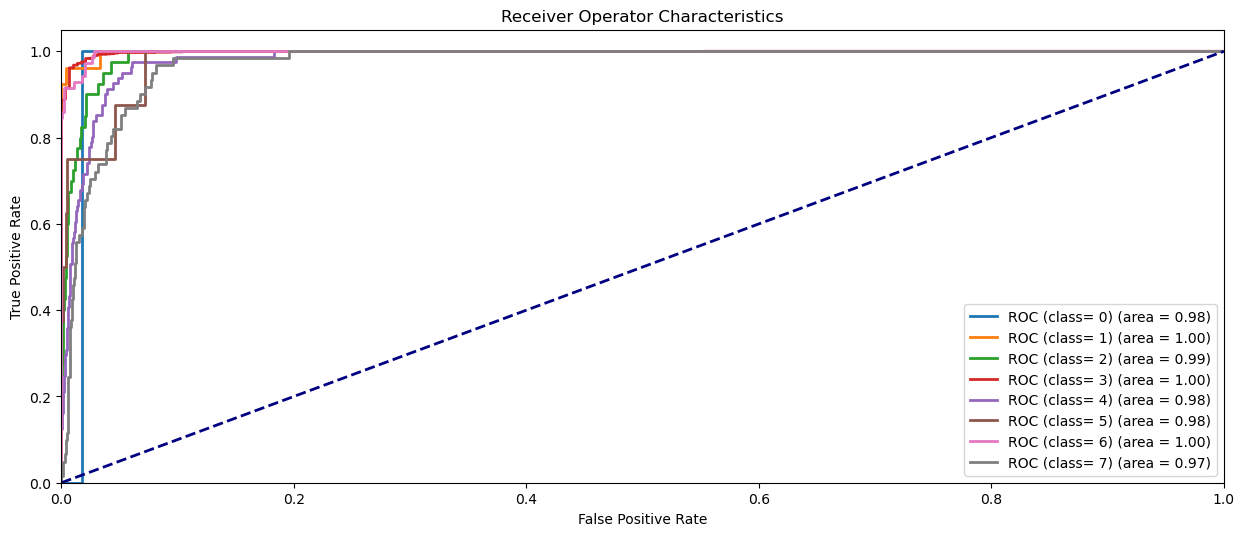

In [69]:
lw = 2
figure(num=None, figsize=(15, 6), dpi=100, facecolor='w', edgecolor='k')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],lw=lw, label='ROC (class= %d) (area = %0.2f)' % (i,roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristics')
plt.legend(loc="lower right")
plt.show()

* oneD

In [70]:
n_classes=8
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yval_b[:, i], yprob_oneD[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

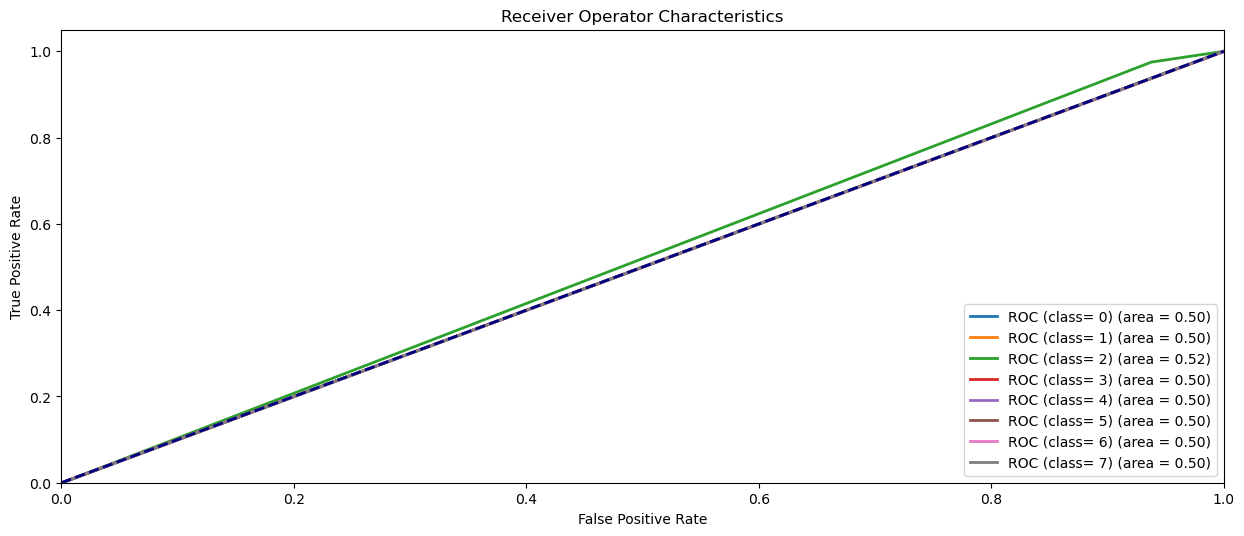

In [71]:
lw = 2
figure(num=None, figsize=(15, 6), dpi=100, facecolor='w', edgecolor='k')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],lw=lw, label='ROC (class= %d) (area = %0.2f)' % (i,roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristics')
plt.legend(loc="lower right")
plt.show()

In [72]:
n_classes=8
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yval_b[:, i], yprob_unTuned[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

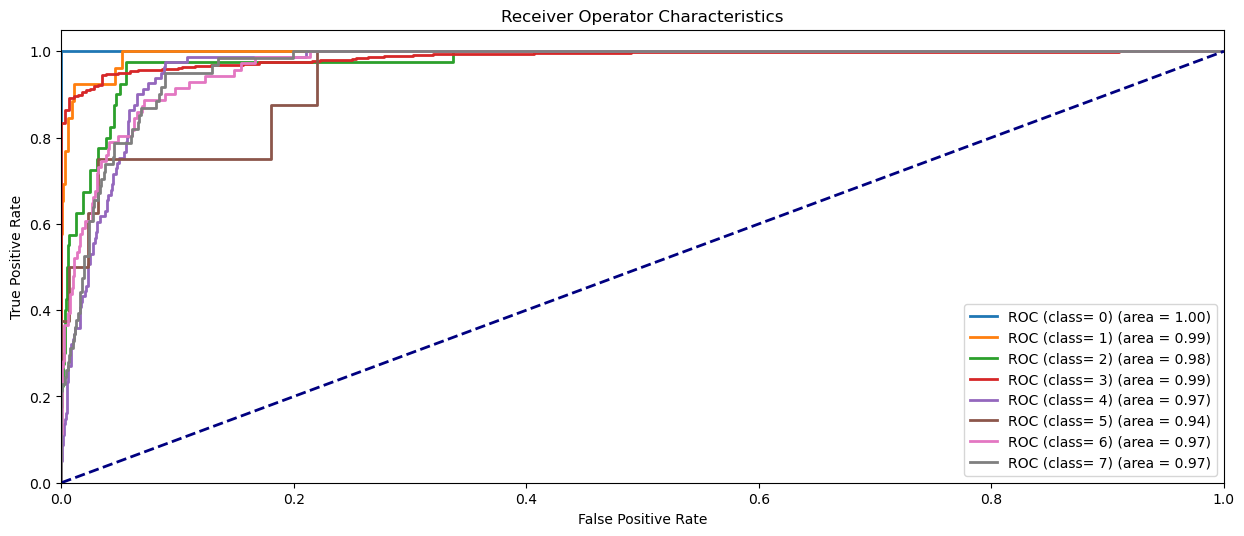

In [73]:
lw = 2
figure(num=None, figsize=(15, 6), dpi=100, facecolor='w', edgecolor='k')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],lw=lw, label='ROC (class= %d) (area = %0.2f)' % (i,roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristics')
plt.legend(loc="lower right")
plt.show()